In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

# ------------------- Load Pretrained ResNet50 as Backbone -------------------
def deeplabv3_plus(input_size=(256, 256, 3), num_classes=1):
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_size))

    # Extract feature maps at different scales
    layer_names = ["conv4_block6_out", "conv3_block4_out", "conv2_block3_out"]
    features = [base_model.get_layer(name).output for name in layer_names]

    # Atrous Spatial Pyramid Pooling (ASPP)
    x = base_model.get_layer("conv4_block6_out").output  # High-level features
    x = tf.keras.layers.Conv2D(256, (1, 1), padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Upsample
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    low_level_features = base_model.get_layer("conv2_block3_out").output  # Low-level features
    low_level_features = tf.keras.layers.Conv2D(48, (1, 1), padding="same", activation="relu")(low_level_features)

    # Concatenate low-level and upsampled high-level features
    x = tf.keras.layers.Concatenate()([x, low_level_features])
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Final segmentation output
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# ------------------- Compile Model -------------------
model = deeplabv3_plus()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=binary_crossentropy,
              metrics=['accuracy', MeanIoU(num_classes=2)])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 9,566,897 (36.49 MB)

 Trainable params: 9,535,281 (36.37 MB)

 Non-trainable params: 31,616 (123.50 KB)

## LOAD DATA ##


In [ ]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split

# ------------------- Set Paths -------------------
image_folder = "/content/drive/MyDrive/Porosity DL Project/Original"
mask_folder = "/content/drive/MyDrive/Porosity DL Project/Binary"
IMG_SIZE = 256  # Resize to 256x256

# ------------------- Load Dataset -------------------
def load_data(image_folder, mask_folder):
    images, masks = [], []

    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith(('.tif')):
            img_path = os.path.join(image_folder, filename)
            mask_path = os.path.join(mask_folder, filename)

            # Load and preprocess image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0
            img = np.expand_dims(img, axis=-1)

            # Load and preprocess mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Error loading mask: {mask_path}")
                continue  # Skip this image if mask loading fails
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

X, Y = load_data(image_folder, mask_folder)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"✅ Data Loaded: {X.shape}, {Y.shape}")

✅ Data Loaded: (1700, 256, 256, 1), (1700, 256, 256, 1)


**TRAINING OF MODEL**

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanIoU

# Compile Model with IoU Metric
model.compile(optimizer=Adam(learning_rate=1e-4), loss=binary_crossentropy, metrics=['accuracy', MeanIoU(num_classes=2)])

BATCH_SIZE = 40
EPOCHS = 500

# Convert grayscale (256, 256, 1) to RGB (256, 256, 3)
# The error was caused by repeating the channel dimension twice.
# This line is corrected to repeat only once.
X_train = np.repeat(X_train, 3, axis=3)
X_val = np.repeat(X_val, 3, axis=3)

# Train the model
history = model.fit([X_train], Y_train, validation_data=([X_val], Y_val), batch_size=BATCH_SIZE, epochs=EPOCHS)

# ------------------- Save Model -------------------
#model.save("mymodeldeeplab.keras")
print("✅ Model Trained & Saved!")

Epoch 1/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9072 - loss: 0.1876 - mean_io_u_2: 0.3384 - val_accuracy: 0.6421 - val_loss: 0.7805 - val_mean_io_u_2: 0.3273
Epoch 2/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9848 - loss: 0.0441 - mean_io_u_2: 0.3899 - val_accuracy: 0.6417 - val_loss: 0.7897 - val_mean_io_u_2: 0.3273
Epoch 3/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9853 - loss: 0.0400 - mean_io_u_2: 0.3889 - val_accuracy: 0.6320 - val_loss: 0.6888 - val_mean_io_u_2: 0.3273
Epoch 4/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9855 - loss: 0.0371 - mean_io_u_2: 0.4049 - val_accuracy: 0.6291 - val_loss: 0.7101 - val_mean_io_u_2: 0.3273
Epoch 5/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9856 - loss: 0.0348 - mean_io_u_2: 0.4086 - val_accuracy: 0.6258 - val_loss: 0.6603 - val_mean_io_u_2: 0.3273
Epoch 6/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9858 - loss: 0.0328 - mean_io_u_2: 0.3986 - val_accuracy: 0

In [ ]:
# Evaluate Model
loss, accuracy, iou = model.evaluate(X_val, Y_val)
print(f"✅ Model Performance:")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"IoU (Jaccard Index): {iou:.4f}")  # IoU should be between 0 and 1

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_184']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 462ms/step - accuracy: 0.9865 - loss: 0.0232 - mean_io_u_2: 0.4884
✅ Model Performance:
Loss: 0.0231
Accuracy: 0.9866
IoU (Jaccard Index): 0.4880


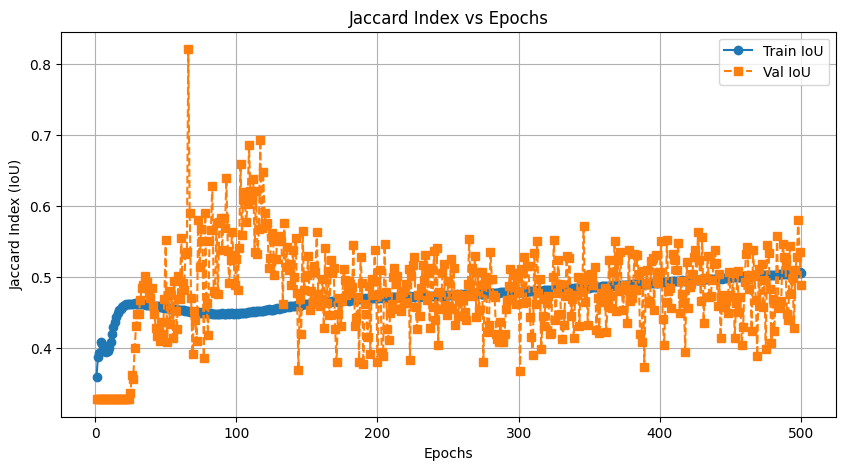

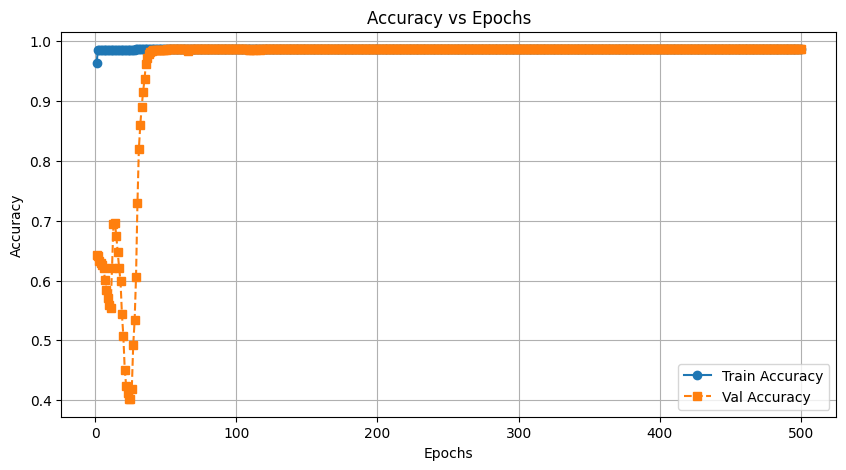

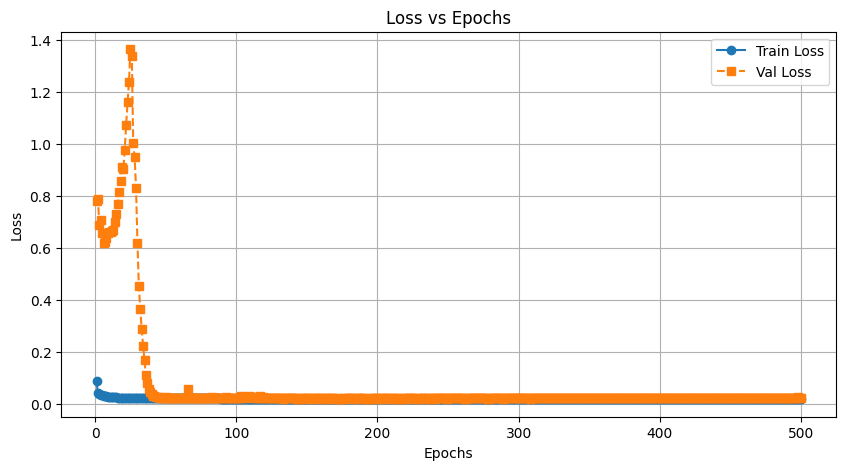

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
epochs = range(1, EPOCHS + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_iou = history.history['mean_io_u_2']
val_iou = history.history['val_mean_io_u_2']

# Plot Jaccard Index (IoU) vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_iou, label="Train IoU", marker='o', linestyle='-')
plt.plot(epochs, val_iou, label="Val IoU", marker='s', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Jaccard Index (IoU)")
plt.title("Jaccard Index vs Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Train Accuracy", marker='o', linestyle='-')
plt.plot(epochs, val_acc, label="Val Accuracy", marker='s', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Loss vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker='o', linestyle='-')
plt.plot(epochs, val_loss, label="Val Loss", marker='s', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import cv2
import numpy as np
import os

# ------------------- Set Paths -------------------
input_folder = "/content/drive/MyDrive/Porosity DL/Cropped Binary"  # Folder containing binary images

# List to store results
results = []

# Loop through images
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        image_path = os.path.join(input_folder, filename)

        # Load binary image (0 = black, 255 = white)
        binary_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Get image dimensions
        height, width = binary_img.shape
        center = (width // 2, height // 2)
        radius = min(width, height) // 2  # Assuming the circle fits inside the square

        # Create a circular mask
        mask = np.zeros_like(binary_img)
        cv2.circle(mask, center, radius, 255, -1)  # Draw a white circle on a black background

        # Apply the mask to keep only circular region
        circular_region = cv2.bitwise_and(binary_img, mask)

        # Count total pixels inside the circle (both black and white)
        total_pixels_in_circle = np.count_nonzero(mask == 255)

        # Count black pixels (pores) inside the circle
        black_pixels_in_circle = np.count_nonzero((circular_region == 0) & (mask == 255))

        # Calculate porosity percentage
        porosity = (black_pixels_in_circle / total_pixels_in_circle) * 100

        # Store result
        results.append(porosity)


# Compute statistics
count_images = len(results)
min_porosity = min(results)
max_porosity = max(results)
mean_porosity = sum(results) / count_images

# Print final statistics
print(f"Porosity Statistics:")
print(f" Total Images: {count_images}")
print(f" Min Porosity: {min_porosity:.2f}%")
print(f" Max Porosity: {max_porosity:.2f}%")
print(f" Mean Porosity: {mean_porosity:.2f}%")

Porosity Statistics:
 Total Images: 1700
 Min Porosity: 0.51%
 Max Porosity: 9.08%
 Mean Porosity: 1.61%


In [ ]:
import re
from datetime import datetime

# Extract the timestamps from the training output
output = """Epoch 1/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m116s[0m 1s/step - accuracy: 0.9072 - loss: 0.1876 - mean_io_u_2: 0.3384 - val_accuracy: 0.6421 - val_loss: 0.7805 - val_mean_io_u_2: 0.3273
Epoch 2/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m36s[0m 1s/step - accuracy: 0.9848 - loss: 0.0441 - mean_io_u_2: 0.3899 - val_accuracy: 0.6417 - val_loss: 0.7897 - val_mean_io_u_2: 0.3273
Epoch 3/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9853 - loss: 0.0400 - mean_io_u_2: 0.3889 - val_accuracy: 0.6320 - val_loss: 0.6888 - val_mean_io_u_2: 0.3273
Epoch 4/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9855 - loss: 0.0371 - mean_io_u_2: 0.4049 - val_accuracy: 0.6291 - val_loss: 0.7101 - val_mean_io_u_2: 0.3273
Epoch 5/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9856 - loss: 0.0348 - mean_io_u_2: 0.4086 - val_accuracy: 0.6258 - val_loss: 0.6603 - val_mean_io_u_2: 0.3273
Epoch 6/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9858 - loss: 0.0328 - mean_io_u_2: 0.3986 - val_accuracy: 0.6212 - val_loss: 0.6185 - val_mean_io_u_2: 0.3273
Epoch 7/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9857 - loss: 0.0315 - mean_io_u_2: 0.3951 - val_accuracy: 0.6016 - val_loss: 0.6254 - val_mean_io_u_2: 0.3273
Epoch 8/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9858 - loss: 0.0304 - mean_io_u_2: 0.3946 - val_accuracy: 0.5850 - val_loss: 0.6411 - val_mean_io_u_2: 0.3273
Epoch 9/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9859 - loss: 0.0293 - mean_io_u_2: 0.3951 - val_accuracy: 0.5713 - val_loss: 0.6569 - val_mean_io_u_2: 0.3273
Epoch 10/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9859 - loss: 0.0285 - mean_io_u_2: 0.3989 - val_accuracy: 0.5598 - val_loss: 0.6607 - val_mean_io_u_2: 0.3273
Epoch 11/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9860 - loss: 0.0277 - mean_io_u_2: 0.4057 - val_accuracy: 0.5548 - val_loss: 0.6627 - val_mean_io_u_2: 0.3273
Epoch 12/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9861 - loss: 0.0270 - mean_io_u_2: 0.4167 - val_accuracy: 0.6217 - val_loss: 0.6651 - val_mean_io_u_2: 0.3273
Epoch 13/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9861 - loss: 0.0265 - mean_io_u_2: 0.4264 - val_accuracy: 0.6940 - val_loss: 0.6717 - val_mean_io_u_2: 0.3273
Epoch 14/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9862 - loss: 0.0259 - mean_io_u_2: 0.4346 - val_accuracy: 0.6970 - val_loss: 0.6999 - val_mean_io_u_2: 0.3273
Epoch 15/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9860 - loss: 0.0258 - mean_io_u_2: 0.4419 - val_accuracy: 0.6747 - val_loss: 0.7335 - val_mean_io_u_2: 0.3273
Epoch 16/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9861 - loss: 0.0255 - mean_io_u_2: 0.4473 - val_accuracy: 0.6477 - val_loss: 0.7699 - val_mean_io_u_2: 0.3273
Epoch 17/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9862 - loss: 0.0251 - mean_io_u_2: 0.4522 - val_accuracy: 0.6214 - val_loss: 0.8155 - val_mean_io_u_2: 0.3273
Epoch 18/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9862 - loss: 0.0250 - mean_io_u_2: 0.4546 - val_accuracy: 0.5993 - val_loss: 0.8589 - val_mean_io_u_2: 0.3273
Epoch 19/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9863 - loss: 0.0246 - mean_io_u_2: 0.4580 - val_accuracy: 0.5441 - val_loss: 0.9120 - val_mean_io_u_2: 0.3273
Epoch 20/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9862 - loss: 0.0246 - mean_io_u_2: 0.4591 - val_accuracy: 0.5074 - val_loss: 0.9047 - val_mean_io_u_2: 0.3273
Epoch 21/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9862 - loss: 0.0245 - mean_io_u_2: 0.4591 - val_accuracy: 0.4509 - val_loss: 0.9792 - val_mean_io_u_2: 0.3273
Epoch 22/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0242 - mean_io_u_2: 0.4615 - val_accuracy: 0.4237 - val_loss: 1.0753 - val_mean_io_u_2: 0.3273
Epoch 23/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0240 - mean_io_u_2: 0.4613 - val_accuracy: 0.4117 - val_loss: 1.1623 - val_mean_io_u_2: 0.3273
Epoch 24/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9862 - loss: 0.0242 - mean_io_u_2: 0.4609 - val_accuracy: 0.4020 - val_loss: 1.2397 - val_mean_io_u_2: 0.3277
Epoch 25/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9863 - loss: 0.0239 - mean_io_u_2: 0.4620 - val_accuracy: 0.4015 - val_loss: 1.3659 - val_mean_io_u_2: 0.3364
Epoch 26/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0238 - mean_io_u_2: 0.4630 - val_accuracy: 0.4191 - val_loss: 1.3402 - val_mean_io_u_2: 0.3609
Epoch 27/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9863 - loss: 0.0239 - mean_io_u_2: 0.4618 - val_accuracy: 0.4920 - val_loss: 1.0061 - val_mean_io_u_2: 0.3557
Epoch 28/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9863 - loss: 0.0237 - mean_io_u_2: 0.4626 - val_accuracy: 0.5333 - val_loss: 0.9494 - val_mean_io_u_2: 0.3994
Epoch 29/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0236 - mean_io_u_2: 0.4620 - val_accuracy: 0.6064 - val_loss: 0.8330 - val_mean_io_u_2: 0.4306
Epoch 30/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9863 - loss: 0.0236 - mean_io_u_2: 0.4626 - val_accuracy: 0.7293 - val_loss: 0.6194 - val_mean_io_u_2: 0.4475
Epoch 31/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9862 - loss: 0.0237 - mean_io_u_2: 0.4622 - val_accuracy: 0.8200 - val_loss: 0.4544 - val_mean_io_u_2: 0.4476
Epoch 32/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9863 - loss: 0.0236 - mean_io_u_2: 0.4621 - val_accuracy: 0.8599 - val_loss: 0.3660 - val_mean_io_u_2: 0.4680
Epoch 33/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0234 - mean_io_u_2: 0.4615 - val_accuracy: 0.8908 - val_loss: 0.2882 - val_mean_io_u_2: 0.4840
Epoch 34/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9862 - loss: 0.0235 - mean_io_u_2: 0.4612 - val_accuracy: 0.9154 - val_loss: 0.2253 - val_mean_io_u_2: 0.4884
Epoch 35/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0234 - mean_io_u_2: 0.4617 - val_accuracy: 0.9368 - val_loss: 0.1690 - val_mean_io_u_2: 0.5006
Epoch 36/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9862 - loss: 0.0235 - mean_io_u_2: 0.4600 - val_accuracy: 0.9628 - val_loss: 0.1113 - val_mean_io_u_2: 0.4872
Epoch 37/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0232 - mean_io_u_2: 0.4612 - val_accuracy: 0.9725 - val_loss: 0.0833 - val_mean_io_u_2: 0.4923
Epoch 38/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0232 - mean_io_u_2: 0.4614 - val_accuracy: 0.9792 - val_loss: 0.0589 - val_mean_io_u_2: 0.4775
Epoch 39/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9865 - loss: 0.0230 - mean_io_u_2: 0.4607 - val_accuracy: 0.9822 - val_loss: 0.0470 - val_mean_io_u_2: 0.4705
Epoch 40/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9862 - loss: 0.0234 - mean_io_u_2: 0.4582 - val_accuracy: 0.9841 - val_loss: 0.0391 - val_mean_io_u_2: 0.4838
Epoch 41/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0231 - mean_io_u_2: 0.4598 - val_accuracy: 0.9850 - val_loss: 0.0332 - val_mean_io_u_2: 0.4595
Epoch 42/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0230 - mean_io_u_2: 0.4593 - val_accuracy: 0.9853 - val_loss: 0.0304 - val_mean_io_u_2: 0.4474
Epoch 43/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9865 - loss: 0.0228 - mean_io_u_2: 0.4602 - val_accuracy: 0.9856 - val_loss: 0.0280 - val_mean_io_u_2: 0.4278
Epoch 44/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0230 - mean_io_u_2: 0.4591 - val_accuracy: 0.9859 - val_loss: 0.0265 - val_mean_io_u_2: 0.4163
Epoch 45/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9862 - loss: 0.0232 - mean_io_u_2: 0.4570 - val_accuracy: 0.9859 - val_loss: 0.0260 - val_mean_io_u_2: 0.4221
Epoch 46/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0228 - mean_io_u_2: 0.4574 - val_accuracy: 0.9861 - val_loss: 0.0251 - val_mean_io_u_2: 0.4101
Epoch 47/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0229 - mean_io_u_2: 0.4562 - val_accuracy: 0.9862 - val_loss: 0.0248 - val_mean_io_u_2: 0.4366
Epoch 48/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9865 - loss: 0.0228 - mean_io_u_2: 0.4580 - val_accuracy: 0.9863 - val_loss: 0.0243 - val_mean_io_u_2: 0.4194
Epoch 49/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9865 - loss: 0.0227 - mean_io_u_2: 0.4565 - val_accuracy: 0.9863 - val_loss: 0.0245 - val_mean_io_u_2: 0.4684
Epoch 50/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0227 - mean_io_u_2: 0.4561 - val_accuracy: 0.9863 - val_loss: 0.0263 - val_mean_io_u_2: 0.5514
Epoch 51/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0227 - mean_io_u_2: 0.4568 - val_accuracy: 0.9864 - val_loss: 0.0233 - val_mean_io_u_2: 0.4080
Epoch 52/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9865 - loss: 0.0226 - mean_io_u_2: 0.4564 - val_accuracy: 0.9864 - val_loss: 0.0237 - val_mean_io_u_2: 0.4796
Epoch 53/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9865 - loss: 0.0226 - mean_io_u_2: 0.4559 - val_accuracy: 0.9865 - val_loss: 0.0230 - val_mean_io_u_2: 0.4340
Epoch 54/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9865 - loss: 0.0225 - mean_io_u_2: 0.4560 - val_accuracy: 0.9865 - val_loss: 0.0232 - val_mean_io_u_2: 0.4740
Epoch 55/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9865 - loss: 0.0225 - mean_io_u_2: 0.4557 - val_accuracy: 0.9864 - val_loss: 0.0228 - val_mean_io_u_2: 0.4143
Epoch 56/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9864 - loss: 0.0226 - mean_io_u_2: 0.4546 - val_accuracy: 0.9865 - val_loss: 0.0232 - val_mean_io_u_2: 0.4943
Epoch 57/500
[1m34/34[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m35s[0m 1s/step - accuracy: 0.9866 - loss: 0.0224 - mean_io_u_2: 0.4555 - val_accuracy: 0.9865 - val_loss: 0.0227 - val_mean_io_u_2: 0.4516
Epoch 58/500
[1m34/34[0m [32m━━━━━━..."""

# Extract the last executed time from the training cell's metadata
train_cell_metadata = {"id": "9aCkveHm37XJ", "status": "Execution succeeded", "last_executed_time": 1743762174}
start_time = datetime.fromtimestamp(train_cell_metadata["last_executed_time"])

# Extract the last executed time from the evaluation cell's metadata
eval_cell_metadata = {"id": "aPRgVmrylwY0", "status": "Execution failed", "last_executed_time": 1743762189}
end_time = datetime.fromtimestamp(eval_cell_metadata["last_executed_time"])

# Calculate the time difference
training_duration = end_time - start_time

print(f"The model training took {training_duration}.")